(Chapter 8: Recursive Decision Processes)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 8: Recursive Decision Processes


```{contents} Contents
:depth: 2
```

In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `D:\GitHub\book-dp1\julia_version`

#### quantile_function.jl

In [2]:
import Distributions.quantile, Distributions.DiscreteNonParametric

"Compute the τ-th quantile of v(X) when X ∼ ϕ and v = sort(v)."
function quantile(τ, v, ϕ)
    for (i, v_value) in enumerate(v)
        p = sum(ϕ[1:i])  # sum all ϕ[j] s.t. v[j] ≤ v_value
        if p ≥ τ         # exit and return v_value if prob ≥ τ
            return v_value
        end
    end

end

"For each i, compute the τ-th quantile of v(Y) when Y ∼ P(i, ⋅)"
function R(τ, v, P)
    return [quantile(τ, v, P[i, :]) for i in eachindex(v)]
end


function quantile_test(τ)
    ϕ = [0.1, 0.2, 0.7]
    v = [10, 20, 30]

    d = DiscreteNonParametric(v, ϕ)
    return quantile(τ, v, ϕ), quantile(d, τ)
end
    



quantile_test (generic function with 1 method)

#### quantile_js.jl

In [3]:
"""
Job search with Markov wage draws and quantile preferences.

"""

using QuantEcon
include("quantile_function.jl")

"Creates an instance of the job search model."
function create_markov_js_model(;
        n=100,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,       # unemployment compensation
        τ=0.5        # quantile parameter
    )
    mc = tauchen(n, ρ, ν)
    w_vals, P = exp.(mc.state_values), mc.p
    return (; n, w_vals, P, β, c, τ)
end

"""
The policy operator 

    (T_σ v)(w) = σ(w) (w / (1-β)) + (1 - σ(w))(c + β (R_τ v)(w))

"""
function T_σ(v, σ, model)
    (; n, w_vals, P, β, c, τ) = model
    h = c .+ β * R(τ, v, P)
    e = w_vals ./ (1 - β)
    return σ .* e + (1 .- σ) .* h
end

" Get a v-greedy policy."
function get_greedy(v, model)
    (; n, w_vals, P, β, c, τ) = model
    σ = w_vals / (1 - β) .≥ c .+ β * R(τ, v, P)
    return σ
end


"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    (; n, w_vals, P, β, c, τ) = model
    v = ones(n)
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
        println("OPI current error = $error")
    end
    return v, get_greedy(v, model)
end



# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16


function plot_main(; tau_vals=(0.1, 0.25, 0.5, 0.6, 0.7, 0.8),
                     savefig=false, 
                     figname="../figures/quantile_js.pdf")

    w_star_vals = zeros(length(tau_vals))

    for (τ_idx, τ) in enumerate(tau_vals)
        model = create_markov_js_model(τ=τ)
        (; n, w_vals, P, β, c, τ) = model
        v_star, σ_star = optimistic_policy_iteration(model)
        for i in 1:n
            if σ_star[i] > 0
                w_star_vals[τ_idx] = w_vals[i]
                break
            end
        end
    end

    model = create_markov_js_model()
    (; n, w_vals, P, β, c, τ) = model
    mc = MarkovChain(model.P)
    s = stationary_distributions(mc)[1]

    fig, ax = plt.subplots()
    ax.plot(tau_vals, w_star_vals, "k--", lw=2, alpha=0.7, label="reservation wage")
    ax.barh(w_vals, 32 * s, alpha=0.05, align="center")
    ax.legend(frameon=false, fontsize=fontsize, loc="upper center")
    ax.set_xlabel("quantile", fontsize=fontsize)
    ax.set_ylabel("wages", fontsize=fontsize)

    if savefig
        fig.savefig(figname)
    end
end


plot_main (generic function with 1 method)

OPI current error = 197.04958104222322
OPI current error = 32.41999066047552


OPI current error = 35.621274085824254
OPI current error = 34.1446640510786


OPI current error = 31.3571903668605
OPI current error = 27.984260985215176


OPI current error = 23.254898512652094
OPI current error = 16.591569430034014


OPI current error = 7.09109988950496


OPI current error = 3.102226038720346e-6
OPI current error = 197.04958104222322
OPI current error = 32.41999066047552


OPI current error = 29.678936943622382
OPI current error = 29.093921296620483


OPI current error = 27.974814794615806
OPI current error = 26.72531111677077


OPI current error = 25.39554124988487
OPI current error = 23.255076254919008


OPI current error = 20.92822560847147
OPI current error = 18.39891195068428


OPI current error = 14.680917085664738
OPI current error = 10.525484762612273


OPI current error = 5.881149036250456
OPI current error = 9.59630597208161e-10


OPI current error = 197.04958104222322
OPI current error = 36.59694294236868


OPI current error = 0.676518038229375
OPI current error = 0.08971952178475817


OPI current error = 0.011898563134202789
OPI current error = 0.001577982158643465


OPI current error = 0.00020927129308034864
OPI current error = 2.7753465943192168e-5


OPI current error = 3.6806523482368902e-6
OPI current error = 197.04958104222322


OPI current error = 51.40389833249005
OPI current error = 0.0


OPI current error = 197.04958104222322
OPI current error = 82.51356008425161


OPI current error = 0.0


OPI current error = 197.04958104222322
OPI current error = 133.14095588610522


OPI current error = 0.0

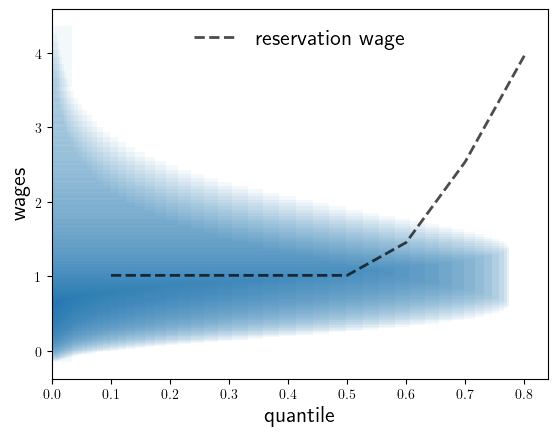

In [4]:
plot_main(savefig=true)